# Bayesian Logit RESCAL 

In this notebook, I'll compare the performance of Bayesian Logistic RESCAL and Bayesian RESCAL with toy dataset.
The dataset will be generated by following the assumption of Bayesian Logistic RESCAL, which means

* Latent feature of entity $e_i \in \mathbb{R}^D$ is drawn from isotropic normal distribution.
* Latent feature of relation $R_k \in \mathbb{R}^{D\times D}$ is also drawn from isotropic normal distribution.
* The probability of triple $x_{ikj}=1$ is equal to $\sigma(1 + \exp(e_i^\top R_k e_j))$


In [1]:
import itertools
import numpy as np
from seq_logit_brescal import PFBayesianLogitRescal
from seq_brescal import PFBayesianRescal
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp

%matplotlib inline

n_dim = 5
n_relation = 10
n_entity = 10
n_particle = 10
total = n_relation * n_entity**2

E = np.random.normal(0, 1.0, size = [n_entity, n_dim])
R = np.random.normal(0, 1.0, size = [n_relation, n_dim, n_dim])

X = np.zeros([n_relation, n_entity, n_entity])
for k, i, j in itertools.product(range(n_relation), range(n_entity), range(n_entity)):
    x = np.dot(np.dot(E[i].T, R[k]), E[j])
    p = 1. / (1. + np.exp(-x))
    X[k, i, j] = np.random.binomial(1, p)

n_test = 16
logit_gain = np.zeros([n_test, total])
normal_gain = np.zeros([n_test, total])

In [2]:
pool = mp.Pool(8)
for nt in range(n_test):
    def finalize(nt):
        # function argument closure
        def inner(rval):
            logit_gain[nt] = np.cumsum([X[s] for s in rval])
        return inner
    _callback = finalize(nt)
    model = PFBayesianLogitRescal(n_dim, n_particles=n_particle)
    pool.apply_async(model.fit, args=(X, np.zeros_like(X), ), callback=_callback)

In [3]:
for nt in range(n_test):
    def finalize(nt):
        # function argument closure
        def inner(rval):
            normal_gain[nt] = np.cumsum([X[s] for s in rval])
        return inner
    _callback = finalize(nt)
    model = PFBayesianRescal(n_dim, n_particles=n_particle, compositional=False)
    pool.apply_async(model.fit, args=(X, np.zeros_like(X), ), callback=_callback)
pool.close()
pool.join()    

### Plot Cumulative Gain

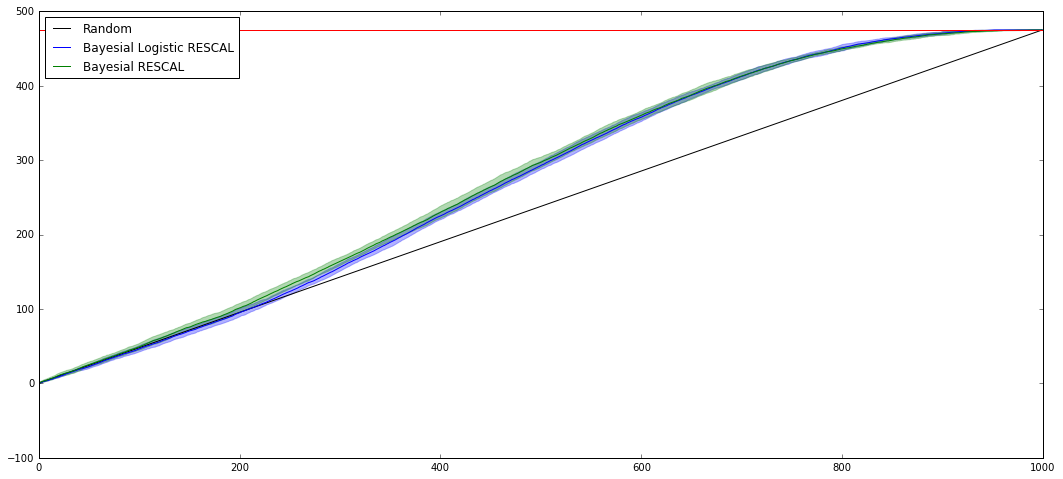

In [8]:
fig = plt.figure(figsize=(18,8))

ratio = np.sum(X)/np.prod(X.shape)
plt.plot(np.cumsum([ratio for i in range(total)]), label='Random', c='k')
plt.plot(np.mean(logit_gain, 0), label='Bayesial Logistic RESCAL', c='b')
plt.fill_between(range(total), np.mean(logit_gain, 0)-np.std(logit_gain, 0), np.mean(logit_gain, 0)+np.std(logit_gain, 0), alpha=0.3, color='b')
    
plt.plot(np.mean(normal_gain, 0), label='Bayesial RESCAL', c='g')
plt.fill_between(range(total), np.mean(normal_gain, 0)-np.std(normal_gain, 0), np.mean(normal_gain, 0)+np.std(normal_gain, 0), alpha=0.3, color='g')

plt.axhline(y=np.sum(X), xmin=0, xmax=total, c='r')
plt.legend(loc='upper left')
plt.show()